# Library

In [1]:
import seaborn as sns
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import GridSearchCV, StratifiedKFold, cross_val_score
from sklearn.pipeline import make_pipeline

from sklearn.metrics import confusion_matrix, accuracy_score, precision_score, recall_score, f1_score

from sklearn.preprocessing import StandardScaler

from sklearn.metrics import roc_curve, roc_auc_score

# Configration

In [153]:
grid_search_flag = 1
params_grid = {
    'C': [1e-2, 1e-1, 1, 1e1, 1e2]
}
threshold_grid = [f / 10 for f in list(range(1, 10, 1))]

In [154]:
threshold_grid

[0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9]

# Import data

In [90]:
target_file = './data/input/input.csv'

df_data = pd.read_csv(target_file)
df_data = df_data.set_index(['horse_id'])

In [91]:
print(df_data.head())
print(df_data.shape)

                2試合前      3試合前      4試合前      5試合前      6試合前      7試合前  \
horse_id                                                                 
1988105984  0.600000  0.333333  0.066667  0.538462  0.083333  0.071429   
1991103531  0.461538  0.666667  0.375000       NaN       NaN       NaN   
1991190011       NaN       NaN       NaN       NaN       NaN       NaN   
1992100038  0.555556  0.636364  0.375000  0.333333  0.833333  0.722222   
1992101546  0.285714  0.250000  0.250000  0.750000  0.333333  0.625000   

              8試合前      9試合前     10試合前     11試合前  target  
horse_id                                                  
1988105984  0.8125  0.363636  0.214286  0.083333     0.0  
1991103531     NaN       NaN       NaN       NaN     0.0  
1991190011     NaN       NaN       NaN       NaN     0.0  
1992100038  0.6875  0.866667  0.800000  0.545455     0.0  
1992101546  0.7000  0.857143  1.000000  0.846154     0.0  
(106843, 11)


# Preprocessing

In [92]:
column  = []
n_game = 2
for c in df_data.columns:
    if c != 'target':
        column.append(str(n_game) + 'games_ago')
        n_game += 1
    else:
        column.append('target')

In [93]:
df_data.columns = column
df_data.head()

,2games_ago,3games_ago,4games_ago,5games_ago,6games_ago,7games_ago,8games_ago,9games_ago,10games_ago,11games_ago,target
horse_id,,,,,,,,,,,
1988105984,0.600000,0.333333,0.066667,0.538462,0.083333,0.071429,0.8125,0.363636,0.214286,0.083333,0.0
1991103531,0.461538,0.666667,0.375000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0
1991190011,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0
1992100038,0.555556,0.636364,0.375000,0.333333,0.833333,0.722222,0.6875,0.866667,0.800000,0.545455,0.0
1992101546,0.285714,0.250000,0.250000,0.750000,0.333333,0.625000,0.7000,0.857143,1.000000,0.846154,0.0


In [94]:
df_data.isnull().sum()

2games_ago      4159
3games_ago      9183
4games_ago     14167
5games_ago     18696
6games_ago     22780
7games_ago     26665
8games_ago     30019
9games_ago     33245
10games_ago    36250
11games_ago    39109
target             0
dtype: int64

#### 2022/11/23
- 6試合以上の成績が残っていない馬は除外

In [95]:
df_data = df_data[df_data['6games_ago'].notnull()]
df_input.head()
#df_input.head()
#df_data.fillna(0.5, inplace=True)
#df_temp.head()
#df_data = df_data.dropna(subset=drop_list)
#df_data = pd.concat([df_temp, df_data[['target']]], axis=1)

,2games_ago,3games_ago,4games_ago,5games_ago,6games_ago,7games_ago,8games_ago,9games_ago,10games_ago,11games_ago
horse_id,,,,,,,,,,
1988105984,0.600000,0.333333,0.066667,0.538462,0.083333,0.071429,0.8125,0.363636,0.214286,0.083333
1992100038,0.555556,0.636364,0.375000,0.333333,0.833333,0.722222,0.6875,0.866667,0.800000,0.545455
1992101546,0.285714,0.250000,0.250000,0.750000,0.333333,0.625000,0.7000,0.857143,1.000000,0.846154
1992102844,0.666667,0.588235,0.266667,0.625000,0.416667,0.388889,0.0625,0.111111,0.750000,0.200000
1992104930,0.833333,0.900000,0.900000,0.800000,0.333333,1.000000,0.7500,0.857143,0.600000,0.636364


In [96]:
df_input.isnull().sum()

2games_ago         0
3games_ago         0
4games_ago         0
5games_ago         0
6games_ago      4084
7games_ago      7969
8games_ago     11323
9games_ago     14549
10games_ago    17554
11games_ago    20413
dtype: int64

In [110]:
df_x = df_data.iloc[:, 0:-6]
df_y = df_data.iloc[:, -1]

In [111]:
x_train, x_test, y_train, y_test = train_test_split(df_x, df_y, test_size=0.2, stratify=df_y, random_state=0)

print('# train 0 : ', len(y_train[y_train==0]))
print('# train 1 : ', len(y_train[y_train==1]))

print('# test 0 : ', len(y_test[y_test==0]))
print('# test 0 : ', len(y_test[y_test==1]))

# train 0 :  63020
# train 1 :  4230
# test 0 :  15756
# test 0 :  1057


/usr/local/Caskroom/miniforge/base/envs/share-envs/lib/python3.10/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


<AxesSubplot:xlabel='target', ylabel='count'>

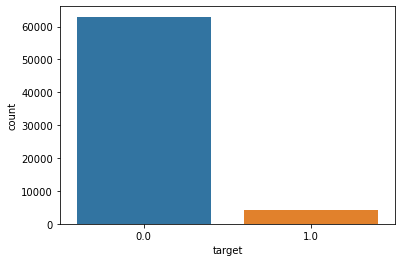

In [114]:
sns.countplot(y_train)

/usr/local/Caskroom/miniforge/base/envs/share-envs/lib/python3.10/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


<AxesSubplot:xlabel='target', ylabel='count'>

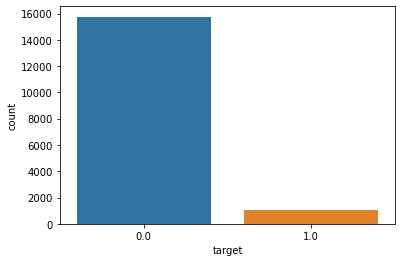

In [115]:
sns.countplot(y_test)

# Pipeline

In [116]:
from sklearn.pipeline import make_pipeline
model_lrbl = LogisticRegression(penalty='l2', random_state=0, class_weight='balanced')
model_lrno = LogisticRegression(penalty='l2', random_state=0, class_weight=None)
#pipe_lrbl = make_pipeline(StandardScaler(), model_lrbl)
#pipe_lrno = make_pipeline(StandardScaler(), model_

- weightをNoneにするとtarget0のデータに過学習してしまい、確率が小さい値に寄ってしまった。（気になるようだったら試してみてください）

In [117]:
skfold = StratifiedKFold(n_splits=10, shuffle=True, random_state=1)

In [118]:
if grid_search_flag:
    clf = GridSearchCV(estimator=model_lrbl, param_grid=param_grid, scoring='roc_auc', cv=10, n_jobs=-1, error_score='raise')
    clf.fit(x_train, y_train)
    best_model = clf.best_estimator_

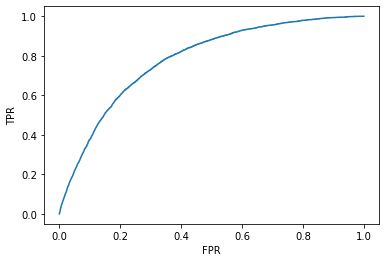

Best AUC score:  0.783123240822736


In [132]:
y_pred = best_model.predict_proba(x_train)[:, 1]

fpr, tpr, thresholds = roc_curve(y_train, y_pred)
plt.plot(fpr, tpr, label="ROC Curve")
plt.xlabel("FPR")
plt.ylabel("TPR")
plt.show()

best_score = roc_auc_score(y_test, clf.predict_proba(x_test)[:, 1])
print("Best AUC score: ", best_score)

In [157]:
best_score = 0
best_threshold = 0
for thr in threshold_grid:
    y_pred = (clf.predict_proba(x_train)[:, 1] > thr) * 1
    temp_score = precision_score(y_true=y_train, y_pred=y_pred)
    if best_score < temp_score:
        best_threshold = thr
        best_score = temp_score

print("Best threshold: ", best_threshold)
print("Best precision: ", best_score)

Best threshold:  0.9
Best precision:  0.43902439024390244


In [158]:
best_threshold

0.9

In [160]:
y_pred_test = (clf.predict_proba(x_test)[:,1] > best_threshold) * 1
print('precision：', precision_score(y_true=y_test, y_pred=y_pred_test))
print('recall：', recall_score(y_true=y_test, y_pred=y_pred_test))
print('f1 score：', f1_score(y_true=y_test, y_pred=y_pred_test))
print('confusion matrix = \n', confusion_matrix(y_true=y_test, y_pred=y_pred_test))

precision： 0.25
recall： 0.002838221381267739
f1 score： 0.005612722170252573
confusion matrix = 
 [[15747     9]
 [ 1054     3]]


# train, testそれぞれのProbabilityを見てみる
## train

<AxesSubplot:ylabel='Count'>

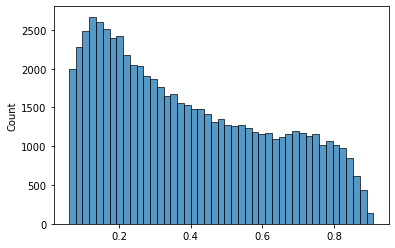

In [126]:
y_pred_train = clf.predict_proba(x_train)[:,1] 
sns.histplot(y_pred_train)

In [127]:
np_y_true_train = y_train.to_numpy()
np_concat = [np_y_true_train, y_pred_train]
df_concat_train = pd.DataFrame(np_concat)
df_concat_train = df_concat_train.T
df_concat_train.head()

,0,1
0,1.0,0.695573
1,0.0,0.247547
2,1.0,0.756709
3,0.0,0.643954
4,0.0,0.638811


<AxesSubplot:xlabel='1', ylabel='Count'>

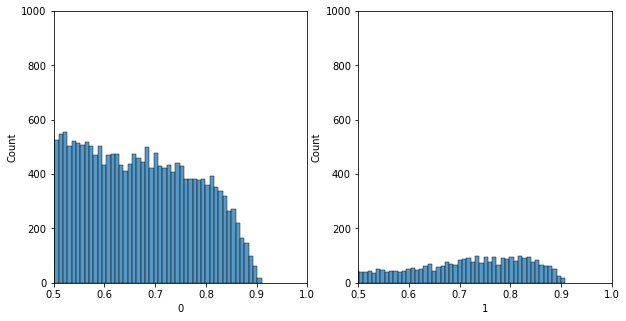

In [161]:
fig, ax = plt.subplots(1, 2, figsize = (10,5))
ax[0].set_xlim(0.5, 1)
ax[0].set_ylim(0, 1000)
ax[0].set_xlabel('0')
ax[1].set_xlim(0.5, 1)
ax[1].set_ylim(0, 1000)
ax[1].set_xlabel('1')
sns.histplot(data=df_concat_train[df_concat_train.iloc[:, 0]==0].iloc[:, 1], ax=ax[0], bins=100)
sns.histplot(data=df_concat_train[df_concat_train.iloc[:, 0]==1].iloc[:, 1], ax=ax[1], bins=100)

## test

<AxesSubplot:xlabel='1', ylabel='Count'>

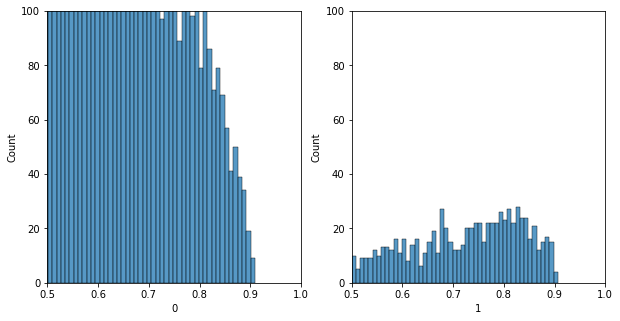

In [162]:
y_pred_test = clf.predict_proba(x_test)[:,1] 
#sns.histplot(y_pred_test)

np_y_true_test = y_test.to_numpy()
np_concat = [np_y_true_test, y_pred_test]
df_concat_test = pd.DataFrame(np_concat)
df_concat_test = df_concat_test.T
df_concat_test.head()

fig, ax = plt.subplots(1, 2, figsize = (10,5))
ax[0].set_xlim(0.5, 1)
ax[0].set_ylim(0, 100)
ax[0].set_xlabel('0')
ax[1].set_xlim(0.5, 1)
ax[1].set_ylim(0, 100)
ax[1].set_xlabel('1')
sns.histplot(data=df_concat_test[df_concat_test.iloc[:, 0]==0].iloc[:, 1], ax=ax[0], bins=100)
sns.histplot(data=df_concat_test[df_concat_test.iloc[:, 0]==1].iloc[:, 1], ax=ax[1], bins=100)

### 2022/11/12
- N/Aを0.5で埋めていることが起因しているのかx=0.5付近のcountが多い。
 - 0.5付近の確率となる馬のデータを確認してみる。
 - 補完値を変更 or 一定の試合数の馬のみにデータを絞る 等も試してみる必要がある
  
- 神様であるtestを見ると、このモデルでは上手くthresholdを設定してもprecsionを上げることは難しそう。モデルの変更か相当素晴らしい特徴量を追加する必要がある？\

### 2022/11/23
- トレーニングデータは値補完することを諦め、6試合以上の成績がある馬のみにしぼることでprecisionは0.15→0.25程度に向上した。やはり試合数を重ねた馬でないと予測は難しい気がする